In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights

from Model_calibration_dataset import get_cifar10_classes
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

In [2]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])
train_dataset, val_dataset, test_data = get_cifar10_classes(transform_train, transform_test)

# Create dataloader
batch_size=128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

# Define the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 1)  # binary classification
model.to(device)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
# Train
lr = 0.001
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/10, Loss: 0.5869
Epoch 2/10, Loss: 0.4354
Epoch 3/10, Loss: 0.3355
Epoch 4/10, Loss: 0.2578
Epoch 5/10, Loss: 0.1978
Epoch 6/10, Loss: 0.1656
Epoch 7/10, Loss: 0.1308
Epoch 8/10, Loss: 0.1021
Epoch 9/10, Loss: 0.0909
Epoch 10/10, Loss: 0.0592


In [ ]:
# Manually implement platt scaling


In [9]:
# Draw reliability curve on the test data before scaling
model.eval()
all_probs = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()
        all_probs.extend(probs)
        all_labels.extend(labels.numpy())
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

print(f'Number of test samples: {len(all_labels)}')
print(f'Number of probabilities: {len(all_probs)}')

Number of test samples: 2000
Number of probabilities: 2000


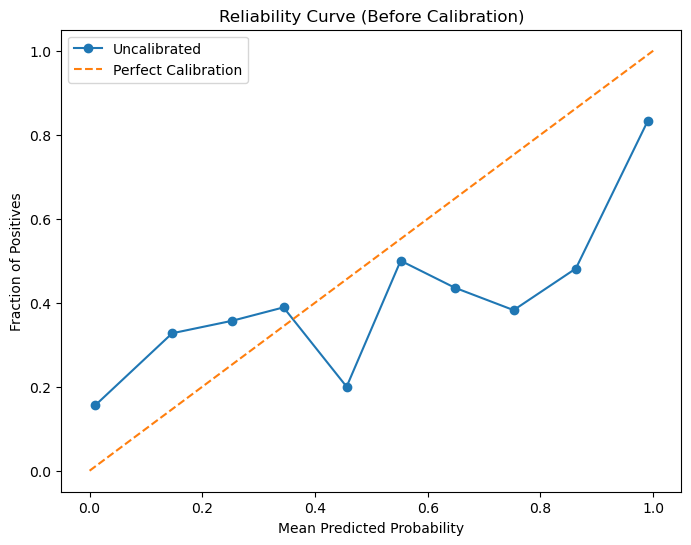

In [10]:

prob_true, prob_pred = calibration_curve(all_labels, all_probs, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Uncalibrated')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.title('Reliability Curve (Before Calibration)')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()

In [14]:
# Implement Platt Scaling on outputs on val set
model.eval()
val_logits = []
val_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images).cpu().numpy().flatten()
        val_logits.extend(outputs)
        val_labels.extend(labels.numpy())
val_logits = np.array(val_logits).reshape(-1, 1)
val_labels = np.array(val_labels)

platt_model = LogisticRegression(solver='lbfgs')
platt_model.fit(val_logits, val_labels)
A, B = platt_model.coef[0][0], platt_model.intercept_[0]  # Retrieve values of A and B 

LogisticRegression()

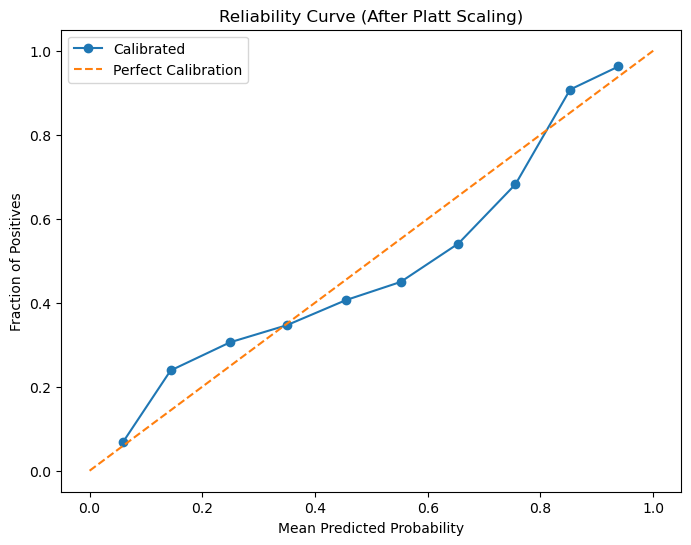

In [19]:
# Draw reliability curve on test data after scaling
test_logits = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        test_logits.extend(outputs.detach().cpu().numpy().flatten())
test_logits = np.array(test_logits).reshape(-1, 1)
calibrated_probs = platt_model.predict_proba(test_logits)[:, 1]  # similar to 1 / (1 + np.exp(-A * test_logits - B))

prob_true_cal, prob_pred_cal = calibration_curve(all_labels, calibrated_probs, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.title('Reliability Curve (After Platt Scaling)')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()

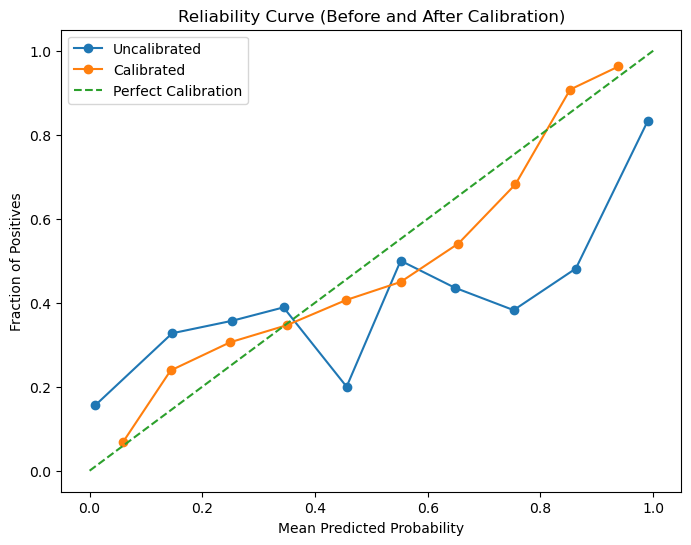

In [18]:
# Draw a combined curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Uncalibrated')
plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.title('Reliability Curve (Before and After Calibration)')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()